# Using ConvNet to classify FHR CTG traces as being from infants with abnormal pH

## Load packages

In [61]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statistics import mode
from tensorflow import keras
from tensorflow.keras import layers

## Set model parameters

In [2]:
# Set outcome
outcome = 'pH'

# Threshold to define outcome as abnormal or not
outcome_threshold = 7.2

# Proportion of time series that should contain complete data
completion_threshold = 70

## Load data

In [3]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [4]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary
filenames = os.listdir(paths.data)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [5]:
# Load meta data and transform
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')
metadata.head()

,1347,2040,1054,1247,1127,1231,1318,1481,1358,1243,...,1421,1236,1256,1435,1404,1118,1018,1447,1152,1229
parameter,,,,,,,,,,,,,,,,,,,,,
pH,7.14,7.23,7.19,7.32,7.35,7.28,7.22,7.29,7.14,7.24,...,7.29,7.27,7.32,7.16,7.18,7.09,7.09,7.14,7.23,7.13
BDecf,8.60,5.27,4.45,-0.86,2.96,-0.06,5.86,2.50,6.52,1.77,...,5.76,5.92,4.73,7.01,7.35,8.76,9.58,7.91,0.16,6.21
pCO2,7.50,6.80,8.00,6.90,5.30,7.50,6.80,6.50,8.40,7.80,...,5.50,5.80,5.30,7.70,7.10,8.70,8.30,7.80,8.60,8.80
BE,-10.80,-7.00,-6.40,-1.00,-4.10,-1.80,-7.90,-4.10,-8.80,-4.10,...,-6.80,-7.40,-5.50,-8.00,-8.40,-11.70,-12.10,-9.80,-2.30,-8.90
Apgar1,10.00,2.00,9.00,9.00,9.00,8.00,5.00,8.00,5.00,10.00,...,9.00,9.00,9.00,9.00,3.00,8.00,8.00,10.00,8.00,9.00


In [6]:
# Get column names (which match up to sample numbers in csv_files)
csv_index = list(metadata)
csv_index[0:3]

['1347', '2040', '1054']

In [7]:
# Preview data from csv file for the first ID in the metadata
csv_files[csv_index[0]]

,seconds,FHR,UC
0,0,128.50,21.5
1,1,128.00,21.5
2,2,128.00,21.5
3,3,127.25,21.5
4,4,127.25,21.0
...,...,...,...
17995,17995,126.00,10.5
17996,17996,126.00,10.5
17997,17997,126.25,10.5
17998,17998,126.25,10.5


## Clean the data

Each csv file contains 18000 rows. Where FHR is missing, it is equal to 0. Below, we show the proportion of records that meet each of the completion targets.

In [8]:
# Create dictionary with keys of 50, 55, 60... and values of []
test_completion = np.arange(0, 101, 5)
completion_dict = {key:[] for key in test_completion}

# For each of the CTG csv files...
for index in csv_index:
    df = csv_files[index]
    # Find percentage of rows where fetal heart rate is provided
    fhr_complete = np.mean(df['FHR'] > 0)*100
    for complete in test_completion:
        if fhr_complete >= complete:
            completion_dict[complete].append(index)

for complete in test_completion:
    print (f'{complete}% complete: {len(completion_dict[complete])}')

0% complete: 552
5% complete: 552
10% complete: 552
15% complete: 552
20% complete: 552
25% complete: 552
30% complete: 552
35% complete: 552
40% complete: 552
45% complete: 552
50% complete: 547
55% complete: 534
60% complete: 521
65% complete: 499
70% complete: 447
75% complete: 389
80% complete: 300
85% complete: 229
90% complete: 152
95% complete: 94
100% complete: 2


In [9]:
# Only keep records whose completion meets threshold
# Get their FHR and save as array list
fhr = []
for file in completion_dict[completion_threshold]:
    fhr.append(csv_files[file].FHR.values)
fhr

[array([128.5 , 128.  , 128.  , ..., 126.25, 126.25, 125.25]),
 array([146.75, 147.  , 147.5 , ...,   0.  ,   0.  ,   0.  ]),
 array([123., 122., 122., ...,  85.,  85.,  85.]),
 array([127.  , 127.  , 127.  , ..., 129.75, 132.25, 132.25]),
 array([164.  , 164.25, 164.25, ..., 163.25, 163.25, 164.25]),
 array([155.  , 155.75, 157.5 , ...,   0.  ,   0.  ,   0.  ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0.,   0.,   0., ..., 114., 116., 116.]),
 array([136.25, 136.25, 136.25, ..., 137.  , 139.5 , 139.5 ]),
 array([164.75, 165.75, 164.75, ...,   0.  ,   0.  ,   0.  ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([130.  , 130.  , 130.25, ...,  69.75,  68.5 ,  68.5 ]),
 array([145.5, 145.5, 145.5, ..., 165.5, 166. , 166. ]),
 array([133.75, 133.75, 133.75, ..., 134.75, 134.75, 134.  ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([121. , 118.5, 118.5, ...,   0. ,   0. ,   0. ]),
 array([ 0.  ,  0.  ,  0.  , ..., 72.25, 72.25, 72.25]),
 array([186.25, 186.25, 186.25, ...,   0.  

**Option 1** (which was originally implemented): 
* **Remove all 0s** - but this would remove gaps between the times, so it is distorting the data as removing appropriate time
* **Truncate all time series to length of the shortest** - but the times still wouldn't line up due to removal of 0s
* **Truncate to the last 30 minutes** - *except* this is not necessarily the last 30 minutes due to the removal of all 0s

In [10]:
# Show original dimensions of list
print('Number of records: ', len(fhr))
print('Min length of time series: ', len(min(fhr, key=len)))
print('Max length of time series: ', len(max(fhr, key=len)))


# Remove 0s
clean_fhr = []
for f in fhr:
    mask = f > 0
    clean_fhr.append(f[mask])

# Show resulting list
display(clean_fhr[0:3])


#  Truncate to shortest length (starting at end - so drops earlier times)
# e.g. f[-2:] would keep the final two values
min_length = min([len(x) for x in clean_fhr])
clean_fhr_truncated = []
for f in clean_fhr:
    clean_fhr_truncated.append(f[-min_length:])
clean_fhr = np.stack(clean_fhr_truncated)

# Show resulting list
display(clean_fhr[0:3])
display(clean_fhr.shape)


# Truncate to last 30 mins
clean_fhr = clean_fhr[:, -30*60:]

# Show resulting list
display(clean_fhr[0:3])
display(clean_fhr.shape)

Number of records:  447
Min length of time series:  14400
Max length of time series:  21620


[array([128.5 , 128.  , 128.  , ..., 126.25, 126.25, 125.25]),
 array([146.75, 147.  , 147.5 , ..., 119.25, 119.25, 119.25]),
 array([123., 122., 122., ...,  85.,  85.,  85.])]

array([[118.5 , 118.5 , 118.75, ..., 126.25, 126.25, 125.25],
       [156.5 , 156.5 , 156.5 , ..., 119.25, 119.25, 119.25],
       [146.  , 147.  , 147.  , ...,  85.  ,  85.  ,  85.  ]])

(447, 10954)

array([[ 86.25,  86.25,  86.25, ..., 126.25, 126.25, 125.25],
       [138.75, 138.75, 139.25, ..., 119.25, 119.25, 119.25],
       [ 76.  ,  79.  ,  79.  , ...,  85.  ,  85.  ,  85.  ]])

(447, 1800)

Looking at the min and max length of the time series, they seem to be longer than 90 minutes, as they contain results for each second but 14400 seconds = 240 minutes (or 4 hours), and 21620 seconds = 360 minutes (or 6 hours).

In [11]:
14400/60

240.0

In [12]:
21620/60

360.3333333333333

Option 2:
* Leave missing data as 0s
* Truncate to the final 90 minutes

In [13]:
# Truncate to last 90 minutes
clean_fhr_truncated = []
for f in clean_fhr:
    clean_fhr_truncated.append(f[-60*90:])
clean_fhr = np.stack(clean_fhr_truncated)

# Show resulting list
display(clean_fhr[0:3])
display(clean_fhr.shape)

array([[ 86.25,  86.25,  86.25, ..., 126.25, 126.25, 125.25],
       [138.75, 138.75, 139.25, ..., 119.25, 119.25, 119.25],
       [ 76.  ,  79.  ,  79.  , ...,  85.  ,  85.  ,  85.  ]])

(447, 1800)

## View outcome

In [14]:
# Extract appropriate records from the metadata
metadata = metadata[completion_dict[completion_threshold]]

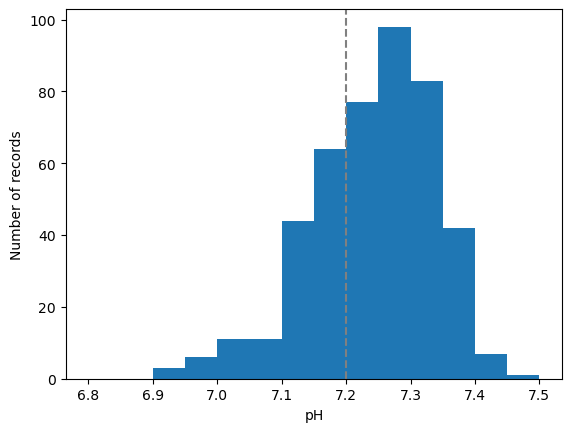

In [15]:
# Show distribution of outcome
plt.hist(metadata.loc[outcome], bins=np.arange(6.8, 7.5, 0.05))
plt.xlabel(outcome)
plt.ylabel('Number of records')
plt.axvline(x=outcome_threshold, color='grey', linestyle='--')

## Define x and y

In [32]:
# X is the time series data
X = clean_fhr

In [33]:
# Y is a boolean, true/false for each depending on outcome
y = (metadata.loc[outcome] < outcome_threshold).values

## Ensure majority cases are no more than double minority cases

In [58]:
'''
# Count of minority class and majority class
minority = (metadata.loc[outcome] < outcome_threshold).value_counts().min()
majority = (metadata.loc[outcome] < outcome_threshold).value_counts().max()

display(minority, majority)

# If size of majority class is more than double minority
if majority > minority*2:
    # Identify the majority class
    majority_class = mode(y)
    print(f'Majority class: {majority_class}')

# Get indices of class "False"
false = [i for i, x in enumerate(y) if ~x]

# Randomly sample minority*2 instances of majority class
random.seed(22)
random.sample(false, minority*2)
'''

139

308

Majority class: False


## Define training and testing

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state=42)

## Scale data

In [20]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [21]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

n_classes = len(np.unique(y_train))

## Create model

2023-10-12 11:49:02.524553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 11:49:02.534124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 11:49:02.534455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

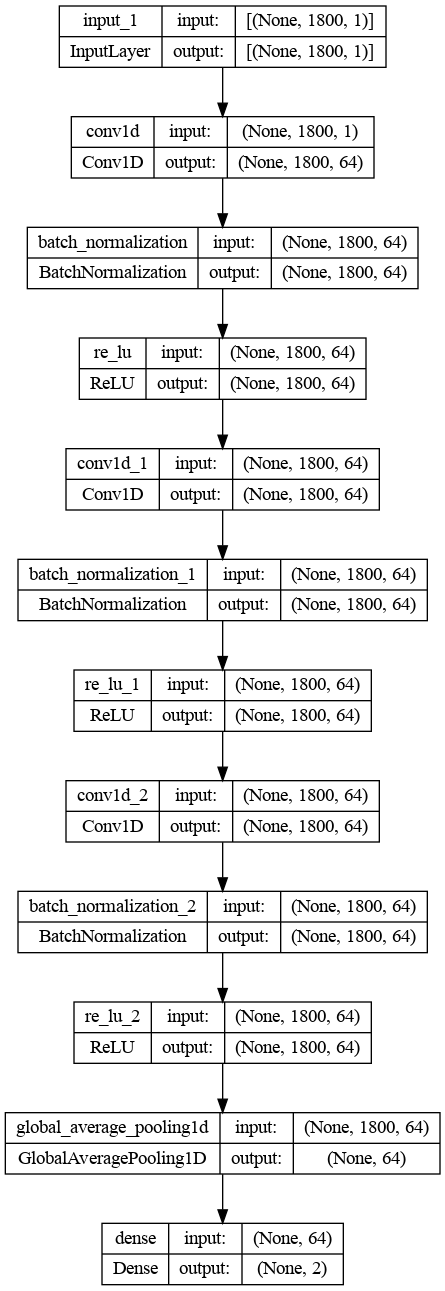

In [22]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    #conv3 = keras.layers.MaxPooling1D(pool_size=2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train_sc.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [23]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train_sc,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500


2023-10-12 11:49:07.878314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-12 11:49:10.182926: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2cec6d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 11:49:10.182964: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-12 11:49:10.192724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 11:49:10.371426: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 10s 152ms/step - loss: 0.6963 - sparse_categorical_accuracy: 0.5522 - val_loss: 0.6820 - val_sparse_categorical_accuracy: 0.6866 - lr: 0.0010
Epoch 2/500
4/9 [============>.................] - ETA: 0s - loss: 0.6229 - sparse_categorical_accuracy: 0.6641

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 38ms/step - loss: 0.6078 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.6866 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 0s 38ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.6402 - val_sparse_categorical_accuracy: 0.6866 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 0s 36ms/step - loss: 0.5869 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.6866 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 0s 38ms/step - loss: 0.5830 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.6205 - val_sparse_categorical_accuracy: 0.6866 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 0s 37ms/step - loss: 0.5901 - sparse_categorical_accuracy: 0.6940 - val_loss: 0.6189 - val_sparse_categorical_accuracy: 0.6866 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 0s 31m

## Evaluate performance

In [24]:
y_pred = model.predict(X_test_sc)[:,1]

4/4 [==============================] - 0s 48ms/step


In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print (f'AUC {roc_auc:0.4f}')

AUC 0.5784


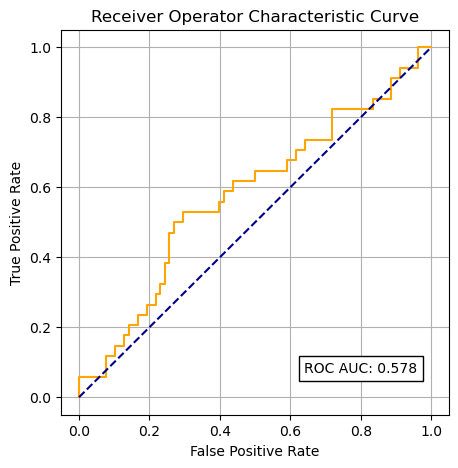

In [26]:
fig = plt.figure(figsize=(5,5))

# Plot ROC
ax1 = fig.add_subplot(111)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'ROC AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()

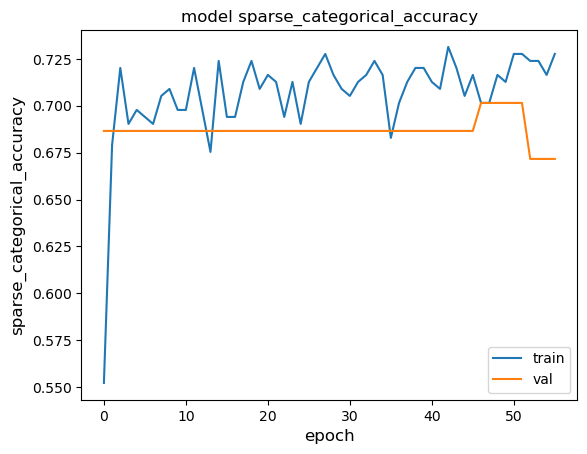

In [27]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()